<a href="https://colab.research.google.com/github/tinacongithub/MPLIA_Ejercicios/blob/main/MPLIA_Ejercicio_adicional_AprendizajeAutomatico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador chistecitos

En este ejercicio adicional pretendo replicar este modelo: https://huggingface.co/Tinaenhugging/clasificador-muchocine-Tinasversion partiendo de un dataset de chistes en español. El modelo resultante podría asignar una calificación numérica de manera automatizada en función de qué tan gracioso es un chiste.

In [2]:
!pip install datasets evaluate transformers[sentencepiece] accelerate -q

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Para este ejercicio voy a usar el dataset mrm8488/CHISTES_spanish_jokes, que contiene chistes en español.

In [4]:
from datasets import load_dataset
raw_dataset = load_dataset("mrm8488/CHISTES_spanish_jokes")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Este es el contenido del dataset:

In [5]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'keywords', 'funny', 'category'],
        num_rows: 2419
    })
})

In [6]:
raw_dataset['train'].to_pandas()

,id,text,keywords,funny,category
0,0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros
1,1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros
2,2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros
3,3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones
4,4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros
...,...,...,...,...,...
2414,2414,Una mujer en la consulta del médico.\n-Hola do...,"doctor,ropa",2,profesiones
2415,2415,Error 0094782: No se detecta ningún teclado pu...,"windows,teclado",2,tematicos
2416,2416,Una chica entra a una iglesia con un buen esco...,"escote,pecho,cura",2,tematicos
2417,2417,Un hombre va a hablar con su jefe:\n-Hola veng...,"boda,jefe",2,familia


Uso el mismo modelo que el clasificador muchocine (Electricidad) para tokenizar el texto.

In [7]:
from transformers import AutoTokenizer, DataCollatorWithPadding

model_checkpoint = "mrm8488/electricidad-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [8]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

In [9]:
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'keywords', 'funny', 'category', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2419
    })
})

In [10]:
tokenized_dataset = tokenized_dataset.rename_column('funny','label')
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'keywords', 'label', 'category', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2419
    })
})

A continuación, divido el dataset en un conjunto de entrenamiento y en un conjunto de test.

In [11]:
from datasets import DatasetDict,Dataset
new_tokenized_dataset = tokenized_dataset["train"].shuffle()
len_dataset = len(tokenized_dataset["train"])
train_dataset = tokenized_dataset["train"][0:int(len_dataset*0.8)]
test_dataset = tokenized_dataset["train"][int(len_dataset*0.8):]
new_dataset = DatasetDict({"train":Dataset.from_dict(train_dataset),"test":Dataset.from_dict(test_dataset)})


In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Una vez que el data set está listo para entrenar y evaluar, defino el modelo.

In [13]:
from transformers import TrainingArguments
training_args = TrainingArguments("clasificador-chistecitos",evaluation_strategy="epoch")

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=5)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at mrm8488/electricidad-base-discriminator and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ahora defino la función para evaluar al modelo.

In [15]:
import evaluate
import numpy as np

def compute_metrics(eval_preds):
  metric = evaluate.load("accuracy")
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

Y el objeto trainer para entrenarlo.

In [16]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

A continuación entreno el modelo.

In [17]:
trainer.train()

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


RuntimeError: The size of tensor a (751) must match the size of tensor b (512) at non-singleton dimension 1

Esta última pieza de código genera el siguiente error:

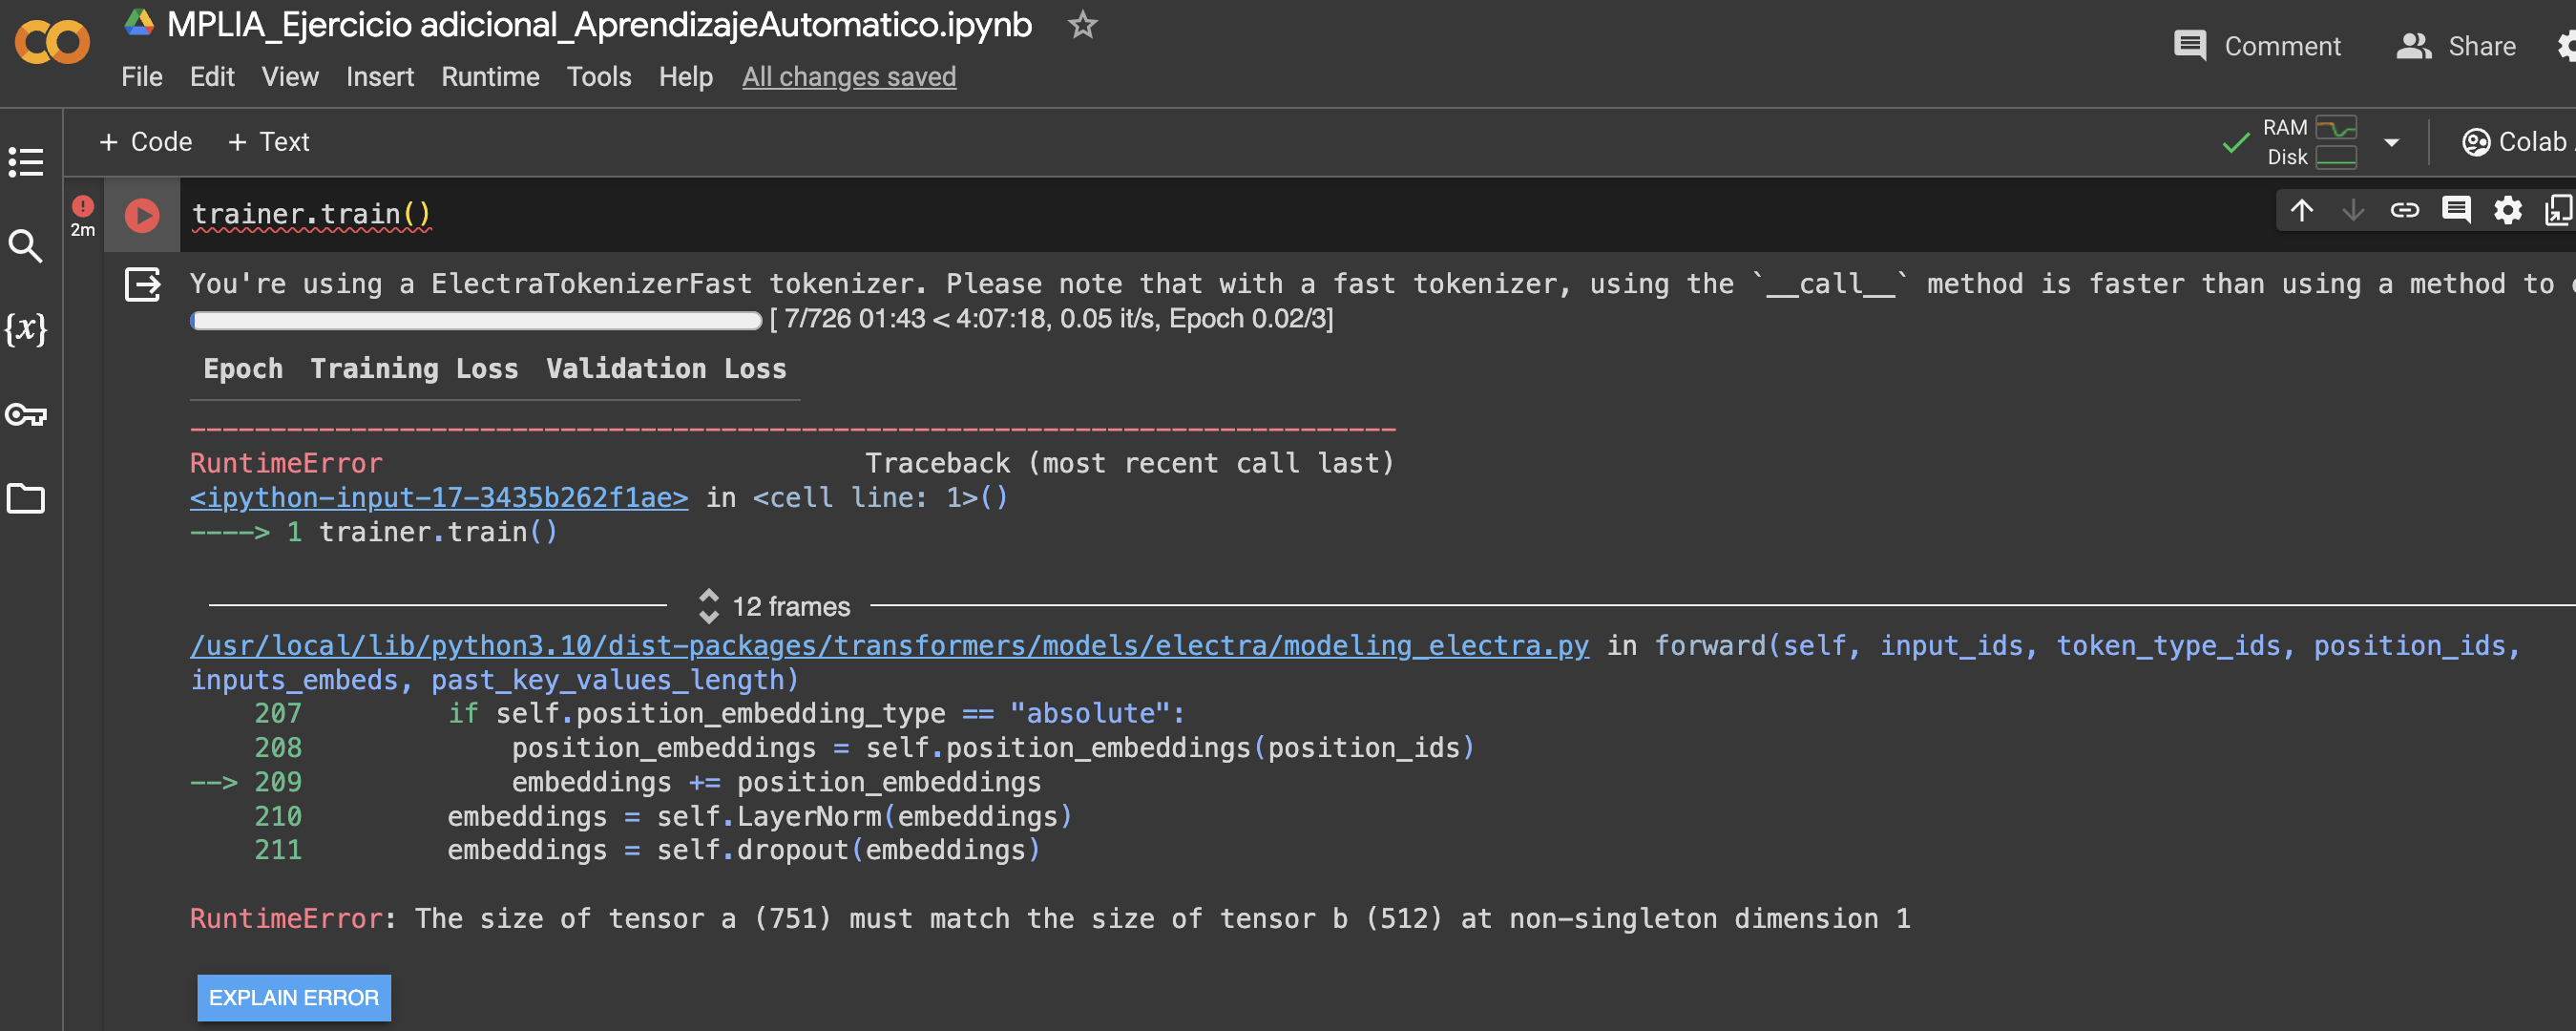